Command: Tsvetkov Fedor, Tsarev Dmitry, Khripach Matvey, Rasshchupkin Denis

Туториал по исследованию временных рядов при помощи Python.

Мы рассмотрим как работать с ARIMA-моделью в Python. Есть несколько различных библиотек, которые позволяют исследовать временные ряды. Мы решили исрользовать sktime, statsmodels, и классическую библиотеку pandas. Где это будет возможно, мы даже сравним возможности этих библиотек, хотя в основном наш выбор пал на самие понятные и негромоздкие решения. 

Наш туториал с теорией и интерактивной частью находится по ссылке https://share.streamlit.io/fmtsvetkov/tssp-tutorial-arima/app.py

In [19]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
from pandas.plotting import register_matplotlib_converters
from sktime.forecasting.model_selection import temporal_train_test_split
register_matplotlib_converters()

In [20]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

Для начала, рассмотрим самые стандартные операции с времеными рядами. У нас есть шаблонный набор даных об авиаперелётах, собранный по конкретонй компании. В следующих нескольких строках мы просто загружаем эти самые данные, и что-нибудь делаем. Если конкретней, строим график, делаем train-test split. Это, в целом, стандартный подход к временным рядам, но от этого не менее важный.

In [21]:
y = load_airline()

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

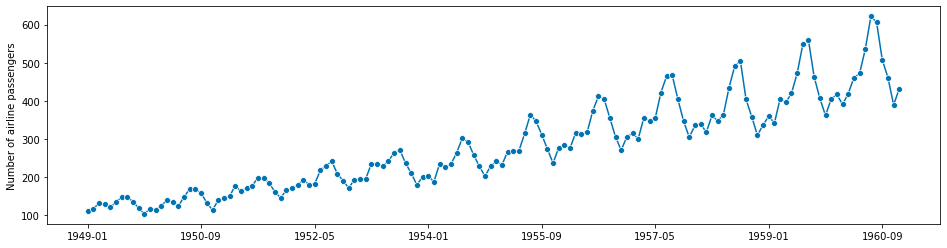

In [22]:
plot_series(y)

На получившийся график можно взглянуть повнимательней. Сразу видна сезонность данных, явные пики и проседания, Ну и прииерно на глазок можно углядеть тренд на увеличение среднегодового колличества пассажиров, даже несмотря на сезонные провалы. 

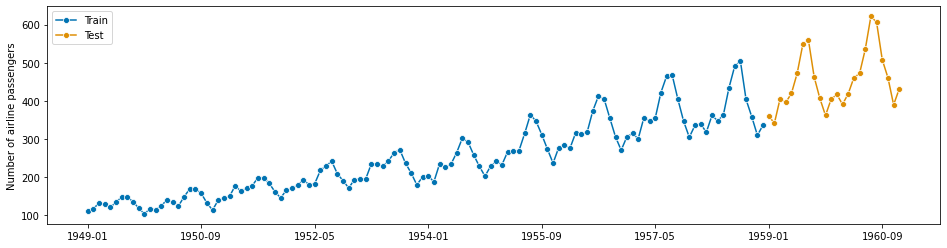

In [23]:

y_train, y_test = temporal_train_test_split(y, test_size=24)
plot_series(y_train, y_test, labels=['Train', 'Test']);

А вот тут мы уже сделали разбивку данных на тестовый и обучающий набор. Синим обозначен обучающий, а золотым - тестовый.

In [24]:
df = pd.DataFrame(y)

С помощью библиотеки pandas мы рассчитываем скользящее среднее, а также стандартное отклонение. График будет представлен чуть ниже.

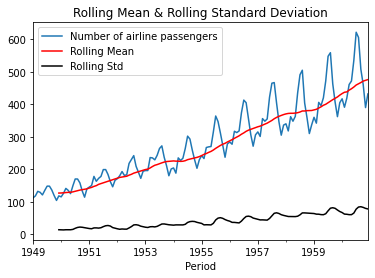

In [25]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
df.plot()
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

Посмотрим на график. Синим показано наблюдаемое количество пассажиров авиалиний. Красным показано скользящее среднее, а чёрным - скользящее стандартное отклонение.

Then we use the augmented Dickey-Fuller test, and show the results.
Здесь мы переходим к немного более сложным вещам. Мы применяем к нашему ряду расширенный тест Дики - Фуллера.

In [26]:
result = adfuller(y)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))
if result[0] > result[4]["5%"]:
    print ("Не удалось отклонить нулевую гипотезу - временной ряд нестационарный")
else:
    print ("Нулевая гипотеза отклонена – временной ряд стационарен")

ADF Statistic: 0.8153688792060442
p-value: 0.9918802434376409
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598
Не удалось отклонить нулевую гипотезу - временной ряд нестационарный


<AxesSubplot:xlabel='Period'>

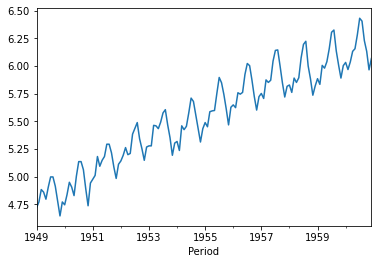

In [27]:
df_log = np.log(y)
df_log.plot()

Далее будет функция, считающая наши скользящие средние, делающая тест Дики - Фуллера, и заодно показывающая график.

In [28]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = timeseries.plot()
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    if result[0] > result[4]["5%"]:
        print ("Не удалось отклонить нулевую гипотезу - временной ряд нестационарный")
    else:
        print ("Нулевая гипотеза отклонена – временной ряд стационарен")

Отметим, что тут мы немного корректируем данные, вычитая среднее.

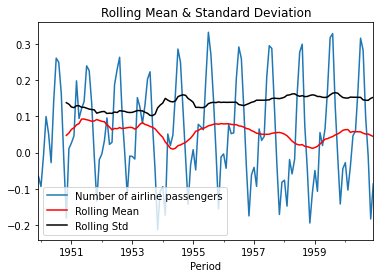

ADF Statistic: -3.1629079913008744
p-value: 0.022234630001242813
Critical Values:
	1%: -3.4865346059036564
	5%: -2.8861509858476264
	10%: -2.579896092790057
Нулевая гипотеза отклонена – временной ряд стационарен


In [29]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

График сверху показывает получившийся результат. Поверх количества пассажиров можно увидеть скользящие соеднее и стандартное отклонение.

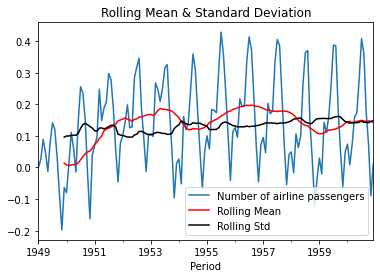

ADF Statistic: -3.6012624201616816
p-value: 0.005736938801511787
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598
Нулевая гипотеза отклонена – временной ряд стационарен


In [30]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

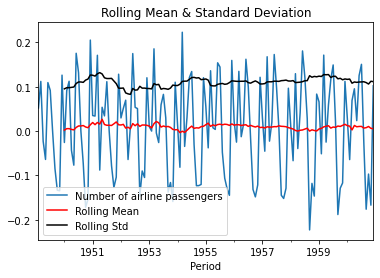

ADF Statistic: -2.7171305983881138
p-value: 0.07112054815086194
Critical Values:
	1%: -3.4825006939887997
	5%: -2.884397984161377
	10%: -2.578960197753906
Не удалось отклонить нулевую гипотезу - временной ряд нестационарный


In [31]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

In [32]:
df_log.index = df_log.index.to_timestamp()

We make a seasonal decomposition, and then finaly use ARIMA. There are several things we do here, from fitting the model and loking at plots to forecasting. 

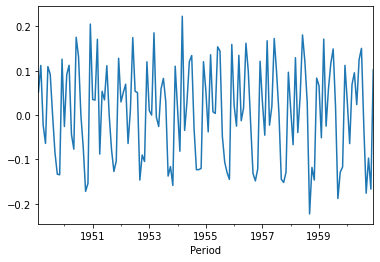

In [33]:
decomposition = seasonal_decompose(df_log);
model = ARIMA(df_log, order=(2,1,2));
results = model.fit()
df_log_shift.plot();
plt.plot(results.fittedvalues, color='red');

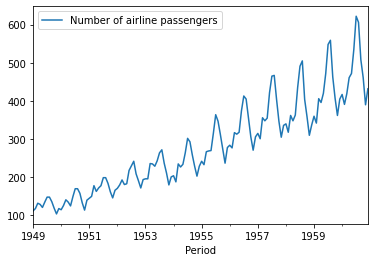

In [34]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log.iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
df.plot()
plt.plot(predictions_ARIMA);

Результаты прогнозирвоания и 95% доверительный интервал

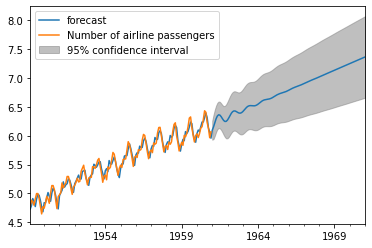

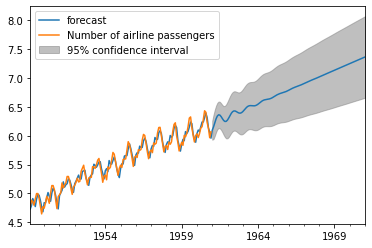

In [35]:
results.plot_predict(1,264)